In [1]:
import json
import torch
import torch.nn as nn
from tqdm import tqdm
from transformers import DistilBertForQuestionAnswering, DistilBertTokenizerFast, AdamW
from torch.utils.data import Dataset, DataLoader
from evaluate import load
from collections import Counter
import string
import re
import matplotlib.pyplot as plt
import os

/home/vnara/.conda/envs/pytorch_env1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

train_data_path = '../Dataset/spoken_train-v1.1.json'
test_data_path = '../Dataset/spoken_test-v1.1.json'
MAX_LENGTH = 512
MODEL_PATH = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_PATH)
epochs = 6

In [3]:
def load_and_preprocess_data(path):
    with open(path, 'rb') as f:
        raw_data = json.load(f)
    contexts, questions, answers = [], [], []
    for group in raw_data['data']:
        for paragraph in group['paragraphs']:
            context = paragraph['context'].lower()
            for qa in paragraph['qas']:
                question = qa['question'].lower()
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append({'text': answer['text'].lower(), 'answer_start': answer['answer_start'], 'answer_end': answer['answer_start'] + len(answer['text'])})
    return contexts, questions, answers

train_contexts, train_questions, train_answers = load_and_preprocess_data(train_data_path)
valid_contexts, valid_questions, valid_answers = load_and_preprocess_data(test_data_path)

In [4]:
def tokenize_and_align_answers(questions, contexts, answers):
    tokenized_inputs = tokenizer(questions, contexts, max_length=MAX_LENGTH, truncation=True, padding=True, return_offsets_mapping=False)
    start_positions = []
    end_positions = []

    for idx, answer in enumerate(answers):
        answer_encoding = tokenizer(answer['text'], max_length=MAX_LENGTH, truncation=True, padding=True)
        start_position = 0
        end_position = 0
        for pos in range(len(tokenized_inputs['input_ids'][idx]) - len(answer_encoding['input_ids']) + 1):
            match = True
            for i in range(1, len(answer_encoding['input_ids']) - 1):
                if answer_encoding['input_ids'][i] != tokenized_inputs['input_ids'][idx][pos + i]:
                    match = False
                    break
            if match:
                start_position = pos + 1
                end_position = pos + i + 1
                break
        start_positions.append(start_position)
        end_positions.append(end_position)

    tokenized_inputs.update({'start_positions': start_positions, 'end_positions': end_positions})
    return tokenized_inputs

train_encodings = tokenize_and_align_answers(train_questions, train_contexts, train_answers)
valid_encodings = tokenize_and_align_answers(valid_questions, valid_contexts, valid_answers)

In [5]:
class QuestionAnswerDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings['input_ids'])

train_dataset = QuestionAnswerDataset(train_encodings)
valid_dataset = QuestionAnswerDataset(valid_encodings)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1)

model = DistilBertForQuestionAnswering.from_pretrained(MODEL_PATH)
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=2e-2)


Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/vnara/.conda/envs/pytorch_env1/lib/python3.11/

In [6]:
def focal_loss_fn(start_logits, end_logits, start_positions, end_positions, gamma):
    
    softmax = nn.Softmax(dim=1)
    start_probabilities = softmax(start_logits)
    inv_start_probabilities = 1 - start_probabilities
    end_probabilities = softmax(end_logits)
    inv_end_probabilities = 1 - end_probabilities
    
    log_softmax = nn.LogSoftmax(dim=1)
    log_start_probabilities = log_softmax(start_logits)
    log_end_probabilities = log_softmax(end_logits)
    
    negative_log_likelihood_loss = nn.NLLLoss()
    
    focal_loss_start = negative_log_likelihood_loss(torch.pow(inv_start_probabilities, gamma) * log_start_probabilities, start_positions)
    focal_loss_end = negative_log_likelihood_loss(torch.pow(inv_end_probabilities, gamma) * log_end_probabilities, end_positions)
    
    return (focal_loss_start + focal_loss_end) / 2

In [7]:
def train(model, dataloader, optimizer):
    model.train()
    losses = []
    accuracies = []
    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        start_logits, end_logits = outputs.start_logits, outputs.end_logits
        
        loss = focal_loss_fn(start_logits, end_logits, start_positions, end_positions, 1)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        start_pred = torch.argmax(start_logits, dim=1)
        end_pred = torch.argmax(end_logits, dim=1)
        start_accuracy = (start_pred == start_positions).sum() / len(start_pred)
        end_accuracy = (end_pred == end_positions).sum() / len(end_pred)
        accuracies.append(start_accuracy.item())
        accuracies.append(end_accuracy.item())

    avg_loss = sum(losses) / len(losses)
    avg_accuracy = sum(accuracies) / len(accuracies)
    return avg_loss, avg_accuracy


In [8]:
def normalize_answer(s):
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

In [9]:
def f1_score_calc(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


In [10]:
def evaluate(model, dataloader):
    model.eval()
    predictions = []
    references = []
    f1_scores = []
    answer_list = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_true = batch['start_positions'].to(device)
            end_true = batch['end_positions'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            start_logits = outputs.start_logits
            end_logits = outputs.end_logits

            start_pred = torch.argmax(start_logits, dim=1)
            end_pred = torch.argmax(end_logits, dim=1)

            for i in range(input_ids.size(0)):
                pred_answer = tokenizer.decode(input_ids[i][start_pred[i]:end_pred[i]+1])
                true_answer = tokenizer.decode(input_ids[i][start_true[i]:end_true[i]+1])
                answer_list.append([pred_answer, true_answer])
                f1_score_value = f1_score_calc(pred_answer, true_answer)
                f1_scores.append(f1_score_value)

    for ans_pair in answer_list:
        if len(ans_pair[0]) == 0:
            ans_pair[0] = "$"
        if len(ans_pair[1]) == 0:
            ans_pair[1] = "$"
        predictions.append(ans_pair[0])
        references.append(ans_pair[1])

    wer_metric = load("wer")
    wer_score = wer_metric.compute(predictions=predictions, references=references)
    avg_f1_score = sum(f1_scores) / len(f1_scores) if f1_scores else 0
    return avg_f1_score, wer_score

f1_scores = []
wer_scores = []
train_loss_list = []
train_accuracy_list = []
model_save_path = 'distilbert_qa_base_model'

if os.path.exists(model_save_path):
    model = DistilBertForQuestionAnswering.from_pretrained(model_save_path)
    tokenizer = DistilBertTokenizerFast.from_pretrained(model_save_path)
    print(f'Model and tokenizer loaded from {model_save_path}')
    f1_score, wer_score = evaluate(model, valid_loader)
    print(f'F1 Score: {f1_score:.4f}, WER Score: {wer_score:.4f}')
else:
    for epoch in range(epochs):
        train_loss, train_accuracy = train(model, train_loader, optimizer)
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        print(f"Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}")

        f1_score, wer_score = evaluate(model, valid_loader)
        f1_scores.append(f1_score)
        wer_scores.append(wer_score)

        print(f"Epoch {epoch + 1}, F1 Score: {f1_score:.4f}, WER Score: {wer_score:.4f}")

    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)

print('F1 Score List:', f1_scores)
print('Word Error Rate List:', wer_scores)

epochs_list = list(range(1, epochs + 1))



Training: 100%|██████████| 2320/2320 [06:06<00:00,  6.34it/s]


Epoch 1, Train Accuracy: 0.4310, Train Loss: 1.9901


Evaluating: 100%|██████████| 15875/15875 [01:18<00:00, 203.18it/s]


Epoch 1, F1 Score: 0.6158, WER Score: 1.2331


Training: 100%|██████████| 2320/2320 [06:07<00:00,  6.31it/s]


Epoch 2, Train Accuracy: 0.6125, Train Loss: 1.1126


Evaluating: 100%|██████████| 15875/15875 [01:18<00:00, 201.49it/s]


Epoch 2, F1 Score: 0.6420, WER Score: 1.0950


Training: 100%|██████████| 2320/2320 [06:08<00:00,  6.30it/s]


Epoch 3, Train Accuracy: 0.7073, Train Loss: 0.7379


Evaluating: 100%|██████████| 15875/15875 [01:18<00:00, 201.36it/s]


Epoch 3, F1 Score: 0.6428, WER Score: 1.1623


Training: 100%|██████████| 2320/2320 [06:08<00:00,  6.30it/s]


Epoch 4, Train Accuracy: 0.7752, Train Loss: 0.4979


Evaluating: 100%|██████████| 15875/15875 [01:18<00:00, 201.39it/s]


Epoch 4, F1 Score: 0.6438, WER Score: 1.1279


Training: 100%|██████████| 2320/2320 [06:07<00:00,  6.31it/s]


Epoch 5, Train Accuracy: 0.8284, Train Loss: 0.3486


Evaluating: 100%|██████████| 15875/15875 [01:18<00:00, 201.34it/s]


Epoch 5, F1 Score: 0.6356, WER Score: 1.0662


Training: 100%|██████████| 2320/2320 [06:08<00:00,  6.30it/s]


Epoch 6, Train Accuracy: 0.8648, Train Loss: 0.2538


Evaluating: 100%|██████████| 15875/15875 [01:18<00:00, 201.54it/s]


Epoch 6, F1 Score: 0.6335, WER Score: 1.0126
F1 Score List: [0.6157728530070766, 0.6420256410541582, 0.6428072149682704, 0.6438159140140183, 0.6355972632298501, 0.6334841052945666]
Word Error Rate List: [1.2331445548231361, 1.094977253736886, 1.1622876241760283, 1.1279361247795006, 1.0662148361340638, 1.0126450654535326]


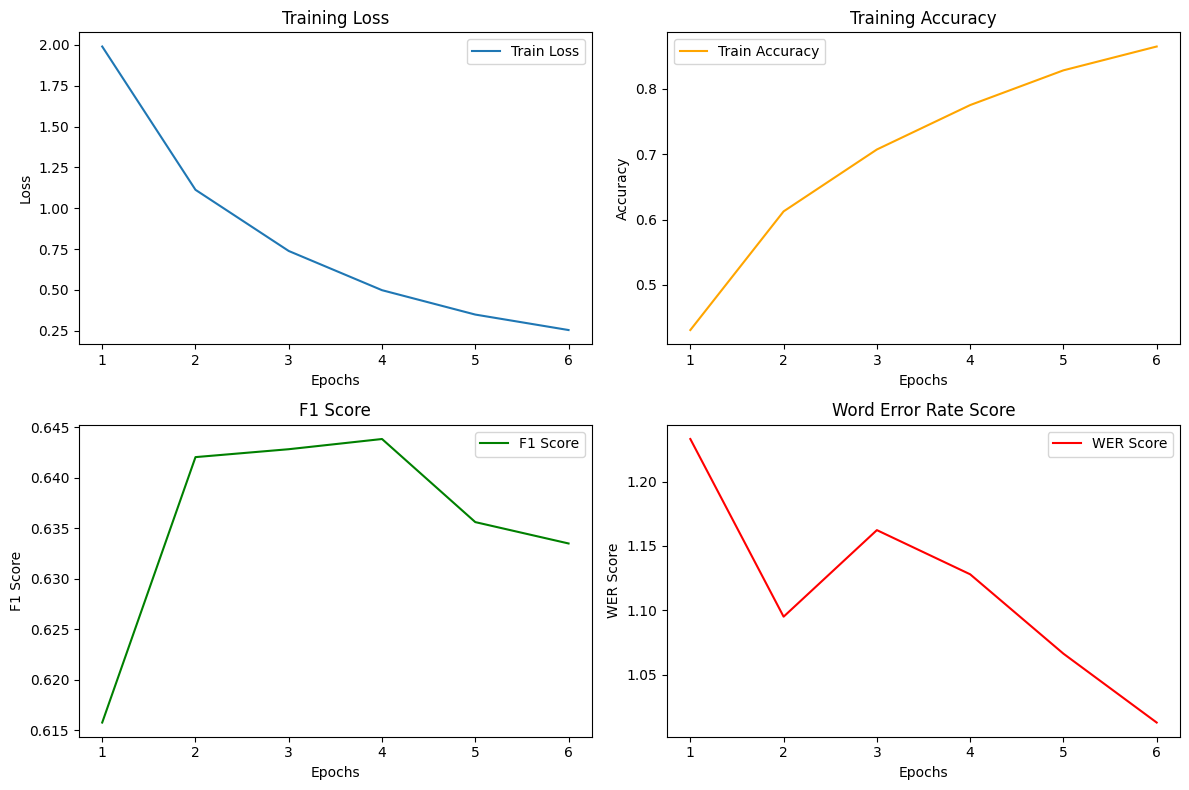

In [11]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs_list, train_loss_list, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs_list, train_accuracy_list, label='Train Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs_list, f1_scores, label='F1 Score', color='green')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs_list, wer_scores, label='WER Score', color='red')
plt.xlabel('Epochs')
plt.ylabel('WER Score')
plt.title('Word Error Rate Score')
plt.legend()

plt.tight_layout()
plt.show()